# Classification

_When you come to a fork in the road, take it_ - Yogi Berra 


Concepts:
- Text classification
- Classification models
- Evaluation

References:
- ISLR


In [78]:
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.unstructured import Edgar
from finds.structured import BusDay, CRSP, PSTAT
from finds.readers import Sectoring
from finds.utils import Store
from secret import paths, credentials
# %matplotlib qt
VERBOSE = 0
store = Store(paths['scratch'], ext='pkl')

In [79]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)

Last FamaFrench Date 2024-03-28 00:00:00


## Text classification

In [80]:
# Retrieve universe of stocks
univ = crsp.get_universe(bd.endmo(20221231))

In [81]:
# lookup company names
comnam = crsp.build_lookup(source='permno', target='comnam', fillna="")
univ['comnam'] = comnam(univ.index)

In [82]:
# lookup ticker symbols
ticker = crsp.build_lookup(source='permno', target='ticker', fillna="")
univ['ticker'] = ticker(univ.index)

In [83]:
# lookup sic codes from Compustat, and map to FF 10-sector code
sic = pstat.build_lookup(source='lpermno', target='sic', fillna=0)
industry = Series(sic[univ.index], index=univ.index)
industry = industry.where(industry > 0, univ['siccd'])
sectors = Sectoring(sql, scheme='codes10', fillna='')   # supplement from crosswalk
univ['sector'] = sectors[industry]

In [84]:
# retrieve 2023 bus10K's
item, form = 'bus10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
found = rows[rows['date'].between(20230101, 20231231)]\
             .drop_duplicates(subset=['permno'], keep='last')\
             .set_index('permno')

### Tagging and Lemmatizing

Lemmatize using WordNet’s built-in morphy function.


In [85]:
# !nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()
bus = {}
for permno in tqdm(found.index):
    if permno not in univ.index:
        continue
    doc = word_tokenize(ed[found.loc[permno, 'pathname']].lower())
    tags = pos_tag(doc)
    nouns = [lemmatizer.lemmatize(w[0]) for w in tags
             if w[1] in ['NN', 'NNS'] and w[0].isalpha() and len(w[0]) > 2]
    if len(nouns) > 100:
        bus[permno] = nouns
store['nouns'] = bus

100%|██████████| 4625/4625 [12:55<00:00,  5.97it/s]


In [86]:
bus = store.load('nouns')
permnos = list(bus.keys())
labels = univ.loc[permnos, 'sector']
data = [" ".join(list(nouns)) for nouns in bus.values()]
classes = sorted(np.unique(labels))

### Vectorizer

- TfIdf

Train/test split of corpus

In [87]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=test_size, random_state=42, stratify=labels)
summary = Series(y_train).value_counts().rename('n_train').to_frame()
summary['n_test'] = Series(y_test).value_counts()
summary['frac_train'] = summary['n_train'] / summary['n_train'].sum()
summary['frac_test'] = summary['n_test'] / summary['n_test'].sum()
print('Stratified Train/Test Split by Event')
summary.sort_values('n_train', ascending=False).round(2)

Stratified Train/Test Split by Event


,n_train,n_test,frac_train,frac_test
sector,,,,
Hlth,705,176,0.25,0.25
Other,609,153,0.21,0.21
HiTec,565,141,0.20,0.20
Manuf,275,69,0.10,0.10
Shops,257,64,0.09,0.09
Durbl,131,33,0.05,0.05
NoDur,116,29,0.04,0.04
Enrgy,75,19,0.03,0.03
Utils,74,18,0.03,0.03


In [88]:
# Tfidf vectorizor
max_df, min_df, max_features = 0.5, 10, 20000
tfidf_vectorizer = text.TfidfVectorizer(
    encoding='latin-1',
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r'\b[a-z_]+\b',
)
x_train = tfidf_vectorizer.fit_transform(X_train)   # sparse array
x_test = tfidf_vectorizer.transform(X_test)
feature_names = tfidf_vectorizer.get_feature_names_out()
print("n_sample x n_features")
DataFrame([[x_train.shape, x_test.shape]],
          index=['data shape:'],
          columns=['train', 'test'])

n_sample x n_features


,train,test
data shape:,"(2847, 10181)","(712, 10181)"


## Classification models

- class_weight: The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

In [89]:
results = dict()
# results = store['classification']

In [90]:
def update_results(name, clf, elapsed):
    """helper to update results dict with train and test accuracy"""
    tic = time.time()
    test_score = clf.score(x_test, y_test)
    toc = time.time() - tic
    results[name] = dict(model=clf,
                         train_score=clf.score(x_train, y_train),
                         test_score=test_score,
                         test_time=toc,
                         train_time=elapsed)
    store['classification'] = results
    print('Accuracy')
    return DataFrame.from_dict(results, orient='index').iloc[:, 1:]

### Naive Bayes

__Generative model__

For classification, there are generally two types of approaches:

- Generative: Estimate probability model, then define the classifier -- e.g. Naive-Bayes
- Discriminative: Directly define the classifier -- e.g. Logistic regression, Perceptron, Support vector machine



__Binomial Naive Bayse__

Naive Bayes is a very simple classifier, yet it still takes all the
feature evidence into account. It is very efficient in terms of
storage space and computation time. Training consists only of storing
counts of classes and feature occurrences as each example is seen. It
performs surprisingly well for classification on many real-world
tasks, because the violation of the independence assumption tends not
to hurt classification performance. 

However, the violation of the independence assumption makes
probability estimates more extreme: the probability will be
overestimated for the correct class and underestimated for the
incorrect class(es). This does become a problem if we're going to be
using the probability estimates themselves -- so Naive Bayes should be
used with caution for actual decision-making with costs and benefits.

Bag of words assumes position doesn't matter, hence the features only
encode word identity and not position.  Naive Bayes assumption is the
conditional independence assumption that the probabilities P$(f_i|c)$
of each feature $f_i$ are independent given the class $c$ and hence
can be `naively' multiplied as follows: $P(f_1, f_2 , ..., f_n|c) =                                            
P(f_1 | c) \cdot P(f_2 |c) \cdot ... \cdot P(f_n |c)$

Since naive Bayes naively multiplies all the feature likelihoods
together, zero probabilities in the likelihood term for any class will
cause the probability of the class to be zero, no matter the other
evidence. The simplest solution is the add-one (Laplace) smoothing.

Let $N_c$ be the number of documents in our training data with class
$c$ and $N_{doc}$ be the total number of documents. Then: $P(c) = N_c / N_{doc}$
$\hat{c} = \mathrm{argmax}_{c \in C} \log P(c) \sum_{i \in n} \log                                             
P(w_i|c)$, where the maximum likelihood estimate of the probability of
frequency of word $w_i$ is $P(w_{i} | c) =                                                                     
\frac{\mathrm{count}(w_{i},c)}{\sum_{w \in V} \mathrm{count}(w, c)}$



__Multinomial Naive Bayes__

__Laplace smoothing__



In [91]:
clf = MultinomialNB(alpha=1.0)
tic = time.time()
clf.fit(x_train, y_train)
toc = time.time() - tic
update_results('naivebayes', clf, toc)

Accuracy


,train_score,test_score,test_time,train_time
naivebayes,0.760801,0.713483,0.003135,0.016976


### Perceptron

- 0-1 loss
- Elasticnet penalty
- OVR

The perceptron update is:
- $\hat{y} \leftarrow \mathrm{sign}(w x$
- $w \leftarrow w + \alpha x$ if $y = +1$ and $y \ne \hat{y}$
- $w \leftarrow w - \alpha x$ if $y = -1$  and $y \ne \hat{y}$

$\Rightarrow w \leftarrow w + \alpha~x~(y - \hat{y})/2$  where $y \in \{-1,~+1\}$ # 

In [92]:
clf = Perceptron(penalty='elasticnet',
                 #n_jobs=4, # -1
                 random_state=0,
                 verbose=VERBOSE)
tic = time.time()
clf.fit(x_train, y_train)
toc = time.time() - tic
update_results('perceptron', clf, toc)

Accuracy


,train_score,test_score,test_time,train_time
naivebayes,0.760801,0.713483,0.003135,0.016976
perceptron,0.949069,0.754213,0.003511,0.572992


### Support Vector Machine

__Margin__
- Hinge loss

__Kernel__
- Linear SVC
- OVR


In [93]:
clf = LinearSVC(multi_class='ovr',
                penalty='l2',
                verbose=VERBOSE)
tic = time.time()
clf.fit(x_train, y_train)
toc = time.time() - tic
update_results('linearsvc', clf, toc)

/home/terence/env3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy


,train_score,test_score,test_time,train_time
naivebayes,0.760801,0.713483,0.003135,0.016976
perceptron,0.949069,0.754213,0.003511,0.572992
linearsvc,0.987706,0.820225,0.005223,0.373052


### Logistic Regression

__Cross-entropy loss__

- logistic loss and binomial
- Softmax
- Multinomial

The logistic regression update is:
 - $P(y=1 | x) \leftarrow 1/(1 + e^{-w x})$
 - $w \leftarrow w + \alpha ~ x ~(1 - P(y=1|x))$ if $y = 1$
- $w \leftarrow w - \alpha ~ x ~(1 - P(y=0|x))$ if $y = 0$

$\Rightarrow w \leftarrow w + \alpha ~ x ~(y - P(y=1|x))$ where $y \in \{0,~1\}$


In [94]:
clf = LogisticRegression(verbose=VERBOSE,
                         penalty='l2',
                         multi_class='multinomial',
                         # n_jobs=-1,      # when multi_class='ovr'
                         max_iter=1000)
tic = time.time()
clf.fit(x_train, y_train)
toc = time.time() - tic
update_results('logistic', clf, toc)

Accuracy


,train_score,test_score,test_time,train_time
naivebayes,0.760801,0.713483,0.003135,0.016976
perceptron,0.949069,0.754213,0.003511,0.572992
linearsvc,0.987706,0.820225,0.005223,0.373052
logistic,0.897085,0.807584,0.004926,2.042012


## Evaluation

__Imbalanced data set__

__Precision__

__Recall__

__F1 score__

The F1 score $= 2~(precision~\times~recall) / (precision~+~recall)$ can be interpreted as a harmonic mean of the precision and recall.  In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

### Precision, Recall and F1-score


In [95]:
# Plot precision, recall, f1

res = DataFrame.from_dict(results, orient='index')
models = {k: v['model'] for k,v in results.items()}

scores, cf_test, cf_train = {}, {}, {}
for ifig, (name, clf) in enumerate(models.items()):
    train_pred = clf.predict(x_train)
    test_pred = clf.predict(x_test)
    scores[name] = {
        'train': metrics.precision_recall_fscore_support(
            y_train, train_pred, average='macro')[:3],
        'test': metrics.precision_recall_fscore_support(
            y_test, test_pred, average='macro')[:3]
    }
    cf = DataFrame(confusion_matrix(y_train, train_pred, labels=classes),
                   index=pd.MultiIndex.from_product([['Actual'], classes]),
                   columns=pd.MultiIndex.from_product([['Predicted'], classes]))
    cf_train[name] = cf
    cf = DataFrame(confusion_matrix(y_test, test_pred, labels=classes),
                   index=pd.MultiIndex.from_product([['Actual'], classes]),
                   columns=pd.MultiIndex.from_product([['Predicted'], classes]))
    cf_test[name] = cf


/home/terence/env3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/terence/env3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [96]:
caption="Model Accuracy"
DataFrame({(metric, sample): [score[sample][i] for score in scores.values()]
           for i, metric in enumerate(['Precision', 'Recall', 'F1-score'])
           for sample in ['train', 'test']},
          index=scores.keys())

Precision              Recall            F1-score          
               train      test     train      test     train      test
naivebayes  0.755631  0.626188  0.542914  0.461119  0.571358  0.470883
perceptron  0.948395  0.715983  0.926773  0.705942  0.936185  0.707481
linearsvc   0.983966  0.817232  0.987891  0.809486  0.985768  0.810462
logistic    0.893775  0.824410  0.849069  0.755437  0.868002  0.780065

### Confusion Matrix


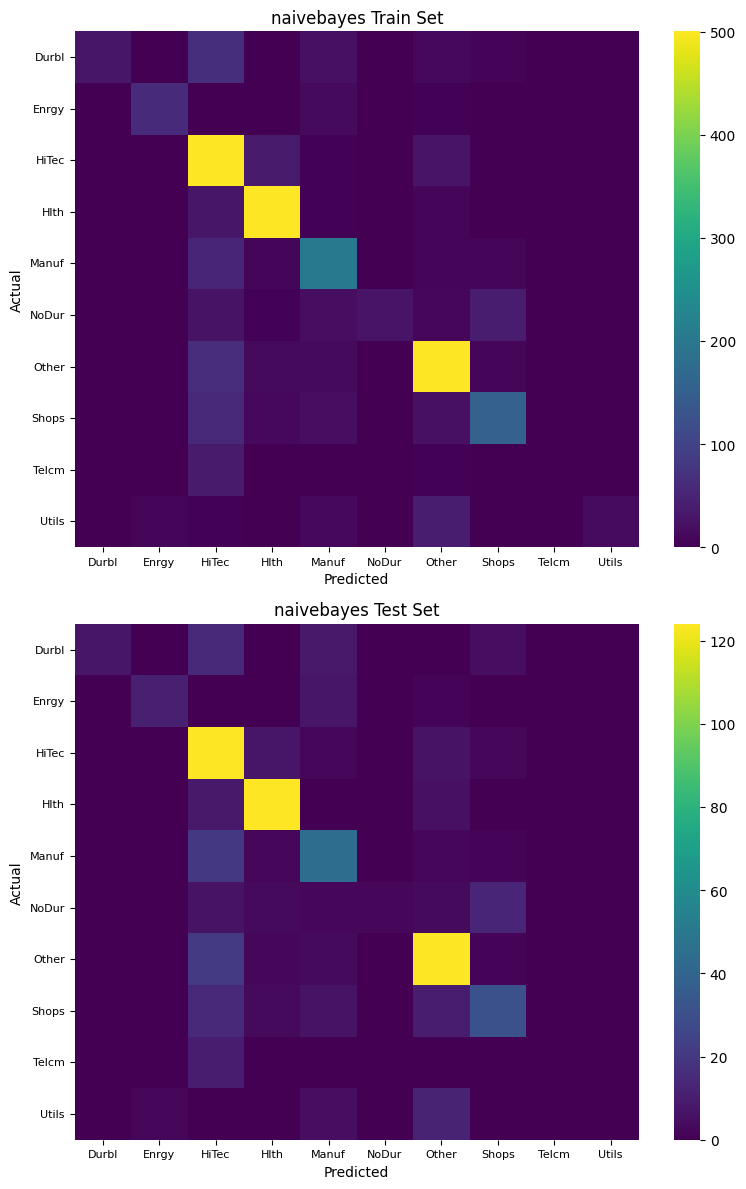

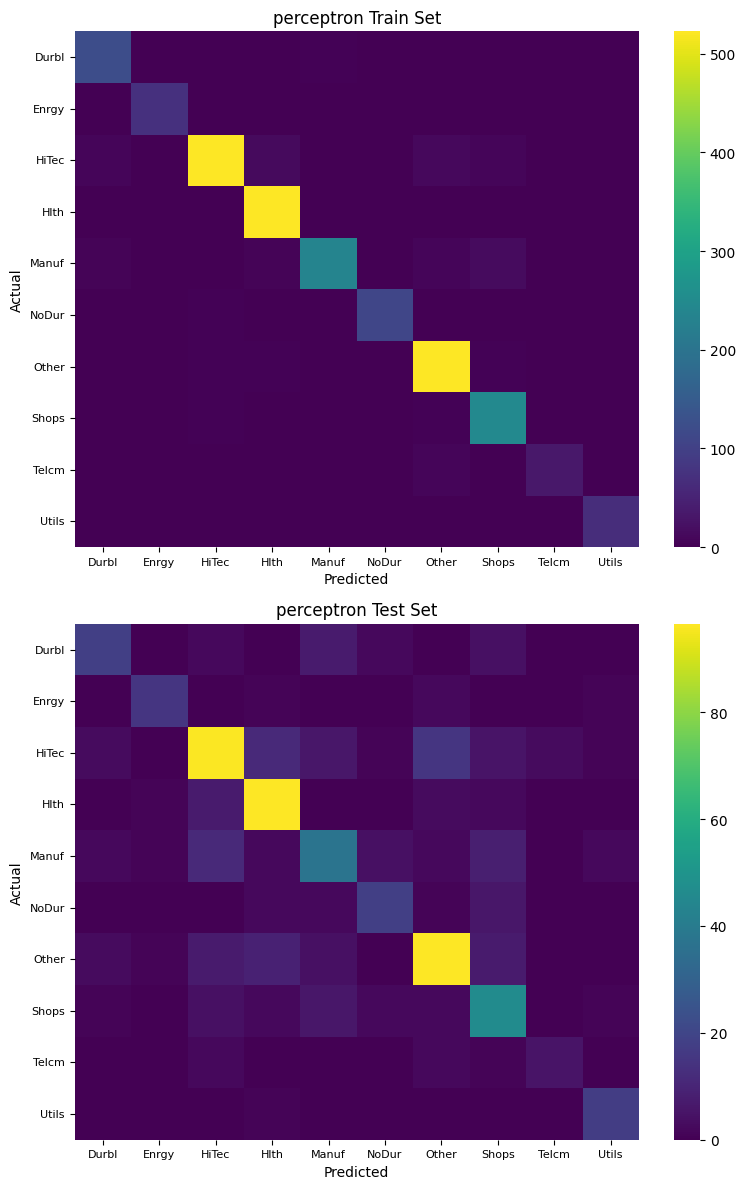

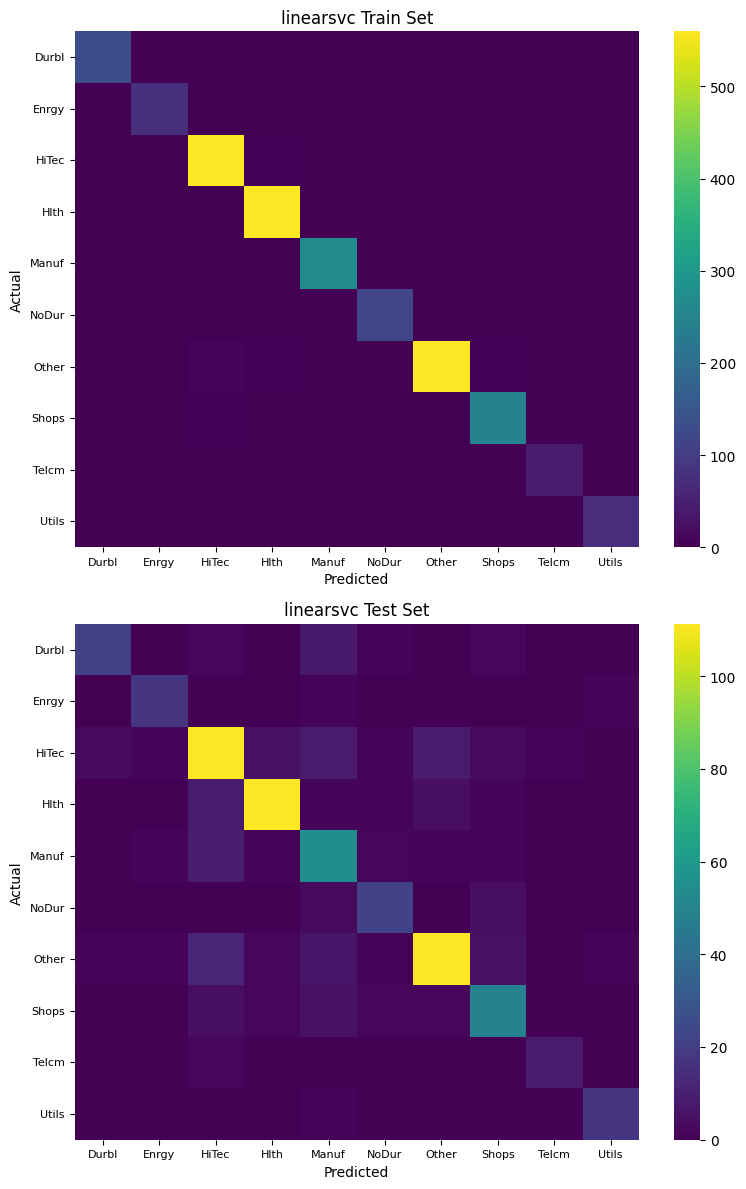

In [97]:
for name, model in models.items():
    fig, axes = plt.subplots(nrows=2, figsize=(8, 12))
    for label, cf, ax in [('Train Set', cf_train[name], axes[0]), 
                          ('Test Set', cf_test[name], axes[1])]:
        sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                    yticklabels=model.classes_,
                    xticklabels=model.classes_)
        ax.set_title(f"{name} {label}")
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.yaxis.set_tick_params(labelsize=8, rotation=0)
        ax.xaxis.set_tick_params(labelsize=8, rotation=0)
        #plt.subplots_adjust(left=0.35, bottom=0.25)
        plt.tight_layout()
plt.close()

### Feature Importance

- Plot by event in each row, then by model in column
- exponentiate NAIVE BAYES to probabilities (generative)

__WordCloud__

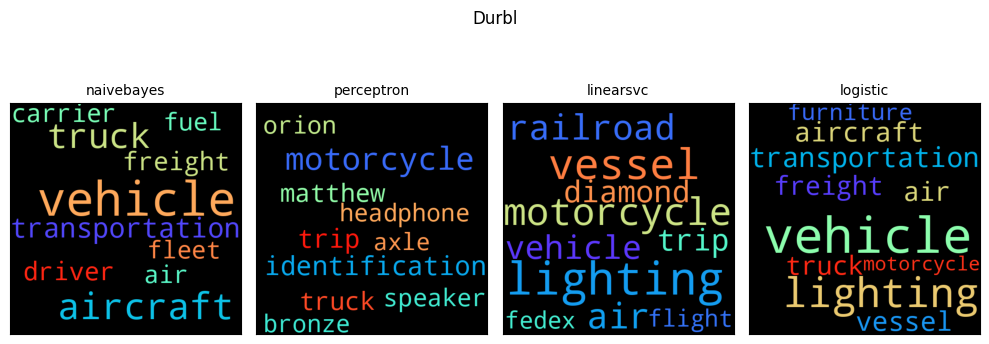

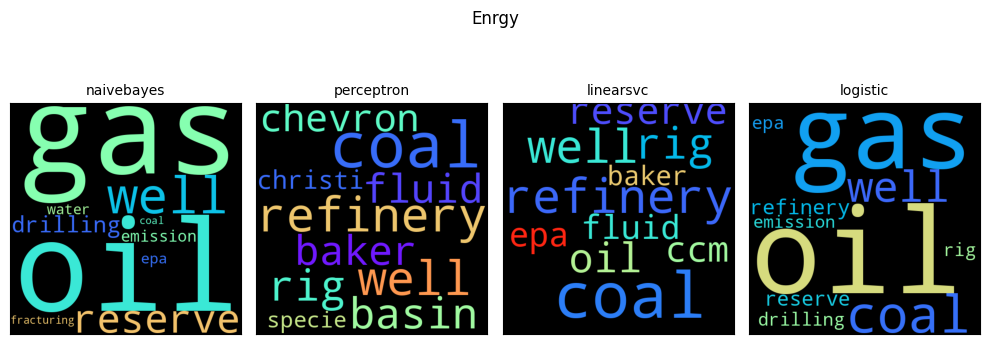

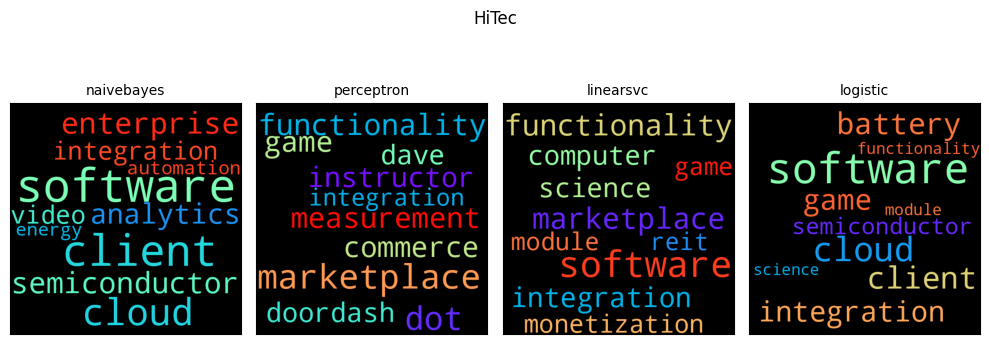

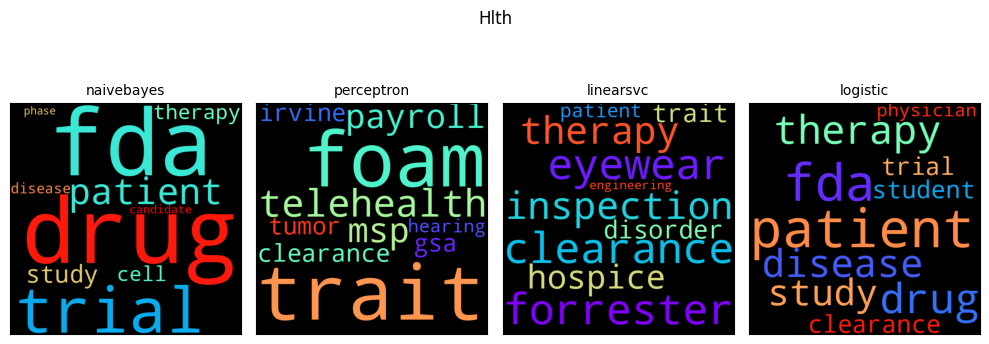

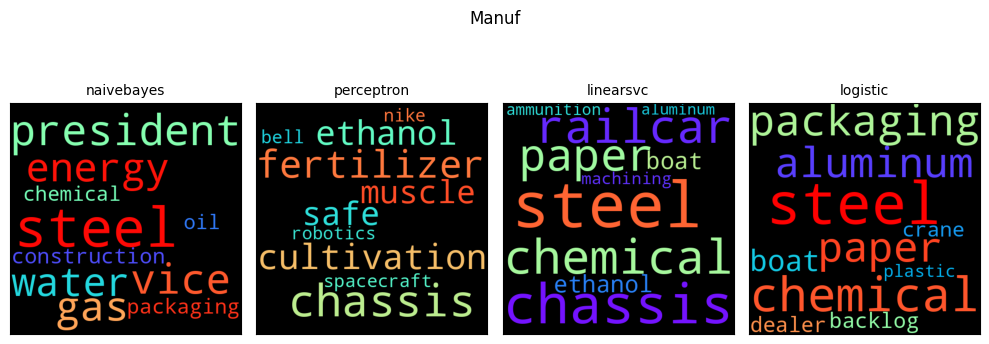

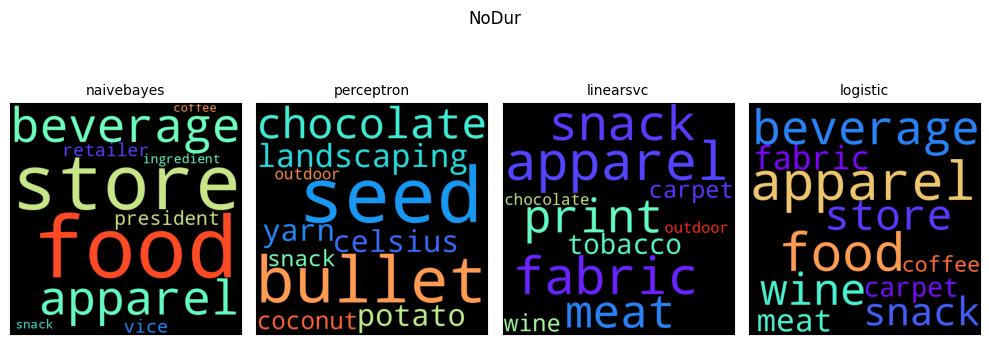

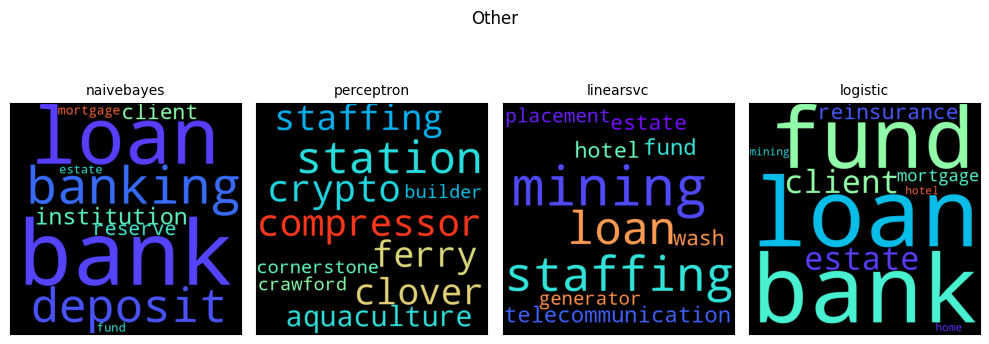

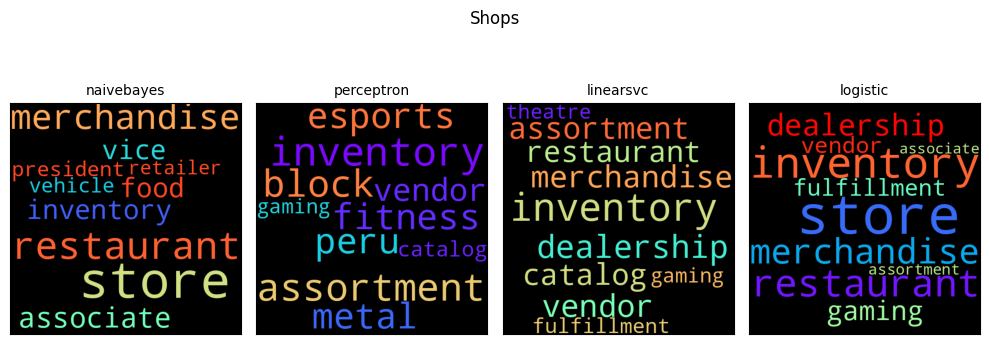

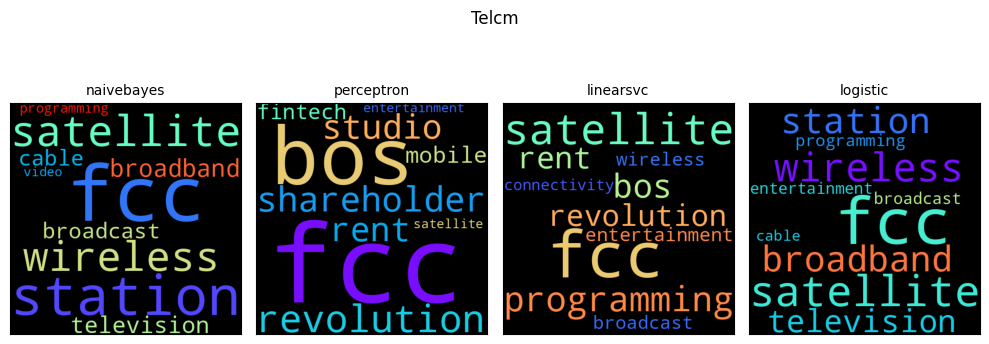

In [98]:
wc = WordCloud(height=500, width=500, prefer_horizontal=1.0, colormap='rainbow') 

top_n = 10
for topic in classes:   # loop over classes
    fig, axes = plt.subplots(ncols=len(models), nrows=1, figsize=(10, 4))
    fig.suptitle(topic)
    for imodel, (ax, name, clf) in enumerate(zip(
            axes, models.keys(), models.values())):
        assert hasattr(clf, 'coef_') or hasattr(clf, 'feature_log_prob_')
        k = clf.classes_.tolist().index(topic)
        #print("Event %d %s:" % (topic, events_[clf.classes_[topic]]))
        if hasattr(clf, 'coef_'):
            importance = clf.coef_[k, :]
        else:
            importance = np.exp(clf.feature_log_prob_[k, :])
        words = {feature_names[i]: importance[i] 
                 for i in importance.argsort()[-top_n:]}
        ax.imshow(wc.generate_from_frequencies(words))
        #Series(words).plot(kind='barh', color=f"C{imodel}", ax=ax)
        #ax.yaxis.set_tick_params(labelsize=7)
        ax.axes.yaxis.set_visible(False)   # make axes ticks invisible
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.set_title(name, fontdict={'fontsize':10})
    fig.tight_layout()
plt.close()
